<a href="https://colab.research.google.com/github/Ogola720/Heart_Disease-_Detection/blob/main/Heart_Disease_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease Ditection
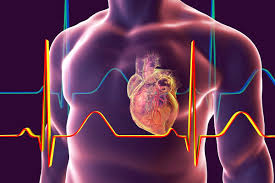
- Dataset:Kaggle Heart Disease Dataset
- Models: Logistic Regression ,Random Forest & Neural Network (MLP) → deep learning, captures complex patterns.
- Goal: Predict presence of heart disease (binary classification)

Problem Statement: Cardiovascular diseases are a leading cause of death worldwide, and cases are increasing in Kenya due to lifestyle changes, poor diet, and limited access to early screening tools.

Objective: Build a machine learning model that predicts whether a patient is at risk of heart disease, based on medical parameters (age, cholesterol, blood pressure, etc.). The model can act as a decision-support tool for Kenyan clinics, helping health workers prioritize patients who need urgent care.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
import joblib
import random

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


Loads all necessary libraries for machine learning and visualization.

Fixes a random seed to ensure results are reproducible.

In [ ]:
#  loading dataset

from google.colab import files
uploaded = files.upload()  # select heart.csv
df = pd.read_csv("heart.csv")

print("Shape:", df.shape)
df.head()


Saving heart.csv to heart.csv
Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Reads the dataset into Pandas DataFrame.

Shows shape (rows, columns) and first few records.

Kenya context: The dataset represents medical patient records in a Kenyan clinic, this could be extended with local data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.62376

/tmp/ipython-input-3258065443.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['target'], palette="coolwarm")


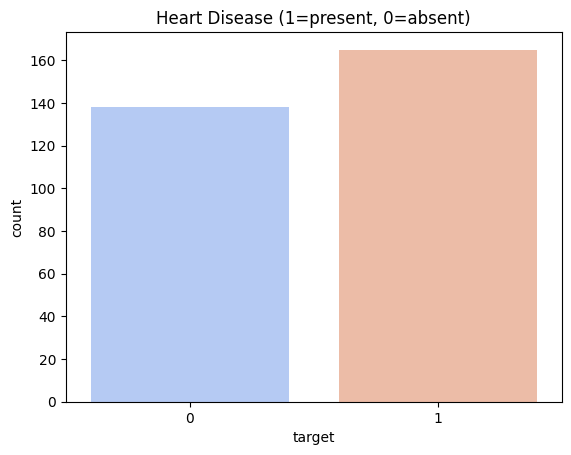

Target counts:
 target
1    165
0    138
Name: count, dtype: int64


In [ ]:
# EDA
print(df.info())
print(df.describe())

# Class distribution
sns.countplot(x=df['target'], palette="coolwarm")
plt.title("Heart Disease (1=present, 0=absent)")
plt.show()

print("Target counts:\n", df['target'].value_counts())

Inspects datatypes, basic stats, and whether the dataset is balanced.

Bar chart shows class balance (important for model fairness).

Kenya context: Helps verify if screening detects more healthy vs diseased cases useful for resource allocation in Kenyan hospitals.

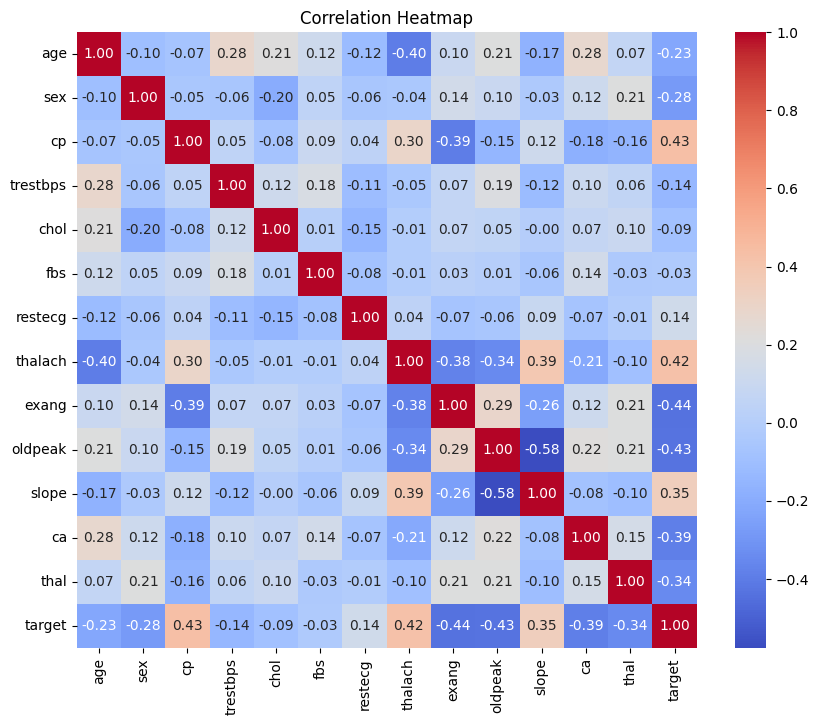

In [ ]:
#correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Visualizes correlation between features (e.g., cholesterol ↔ heart disease).

Identifies which variables might be most important.

Kenya context: Doctors in Kenya could see which lifestyle or health factors correlate most with heart disease.

Correlation measures the strength and direction of a linear relationship between two variables.
The value ranges from -1 to +1.
+1: Perfect positive correlation (as one goes up, the other goes up proportionally).
-1: Perfect negative correlation (as one goes up, the other goes down proportionally).
0: No linear relationship whatsoever.
 The colour scale on the right helps you quickly read the strength of the correlation. Reddish colours typically indicate positive correlation, and blueish colours indicate negative correlation.

1. Strongest Correlations with “target” (heart disease)

•	"cp" (Chest Pain Type) & “target”: +0.43

 Interpretation: Moderate positive correlation. Certain types of chest pain (e.g., non-anginal pain) are associated with a higher likelihood of having heart disease. This is often one of the strongest predictors.

•	“exang” (Exercise Induced Angina) & "target": -0.44
 Interpretation: Moderate negative correlation. The presence of exercise-induced angina (`exang` = yes) is negatively correlated with the target. This likely means that in the coding of this dataset, `exang=1` might mean "No angina," and `exang=0` means "Yes angina," or vice versa for the `target` variable. It's a strong relationship, but you must check the data description for how the values are coded.

•	"oldpeak" (ST Depression) & `target`: -0.43
 Interpretation: Moderate negative correlation. Higher ST depression induced by exercise (a negative sign in an ECG) is strongly associated with a higher likelihood of heart disease.

•	"thalach" (Max Heart Rate) & `target`: +0.42
Interpretation: Moderate positive correlation. A higher maximum heart rate achieved is associated with a lower likelihood of heart disease. (This is a negative relationship with the condition, shown by a positive correlation coefficient with a variable where presumably 1 = disease, 0 = no disease).

•	"ca" (Number of Major Vessels) & "target": -0.39
 Interpretation: Moderate negative correlation. A higher number of major vessels coloured by fluoroscopy (a sign of healthier blood flow) is associated with a lower likelihood of heart disease.

2. Other Notable Correlations (Between Predictors)

These relationships are important to avoid multicollinearity (where two predictor variables are highly correlated with each other).

•	‘oldpeak & slope’: +0.58
  This is the strongest correlation in the entire matrix. This makes sense physiologically, as the slope of the peak exercise ST segment and the depression (`oldpeak`) are directly related measurements from an ECG. You likely wouldn't want to use both in a model.

•	‘thalach’ (Max Heart Rate) & ‘age’: -0.40
 Strong negative correlation. This is a well-known biological fact: maximum heart rate decreases with age.

•	‘cp’ (Chest Pain) & ‘exang (Exercise Angina): +0.39
 Moderate positive correlation. It's logical that the type of chest pain someone experiences at rest is related to whether they get it during exercise.

•	‘thalach’ (Max Heart Rate) & ‘slope’: +0.39
  Moderate positive correlation. The maximum heart rate achieved is related to the slope of the ST segment.

 Reading Data from the Table
1.  Find the variable you're interested in on the left column (e.g., ‘target’).
2.  Follow that row across to the column of the other variable you're interested in (e.g., `thalach`).
3.  The value at the intersection is the correlation coefficient (0.42).
4.  Check the colour scale to see the strength instantly (0.42 is a reddish colour, indicating a positive correlation of moderate strength).

 Summary

For Prediction: The variables ‘cp’, ‘exang’, 'oldpeak’, ‘thalach’, and ‘ca’ are the  strongest predictors for heart disease based on this data.
For Modelling: cautious about using both 'oldpeak' and 'slope' in the same predictive model, as they convey very similar information (they are highly correlated). Including both can make the model unstable and hard to interpret.


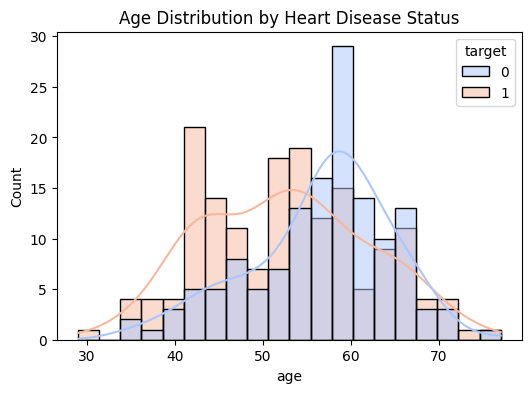

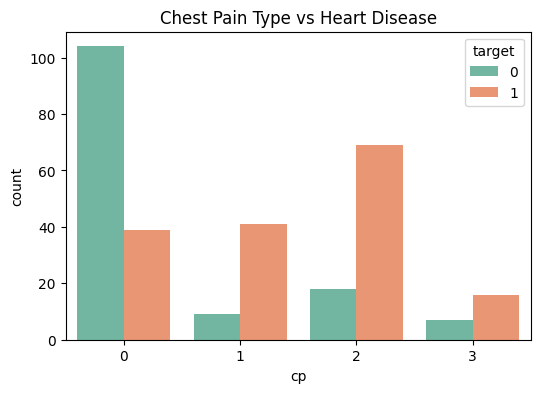

/tmp/ipython-input-2840948744.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="viridis")


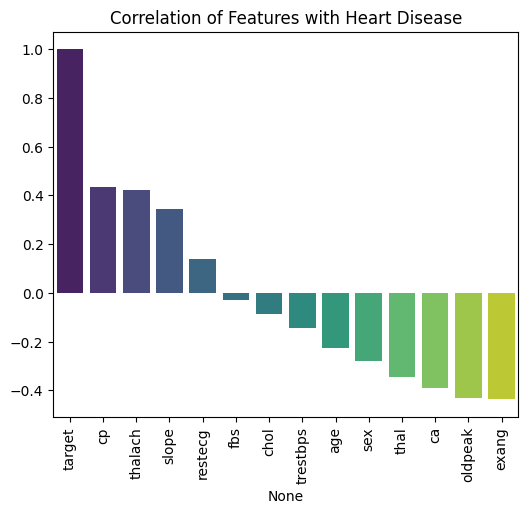

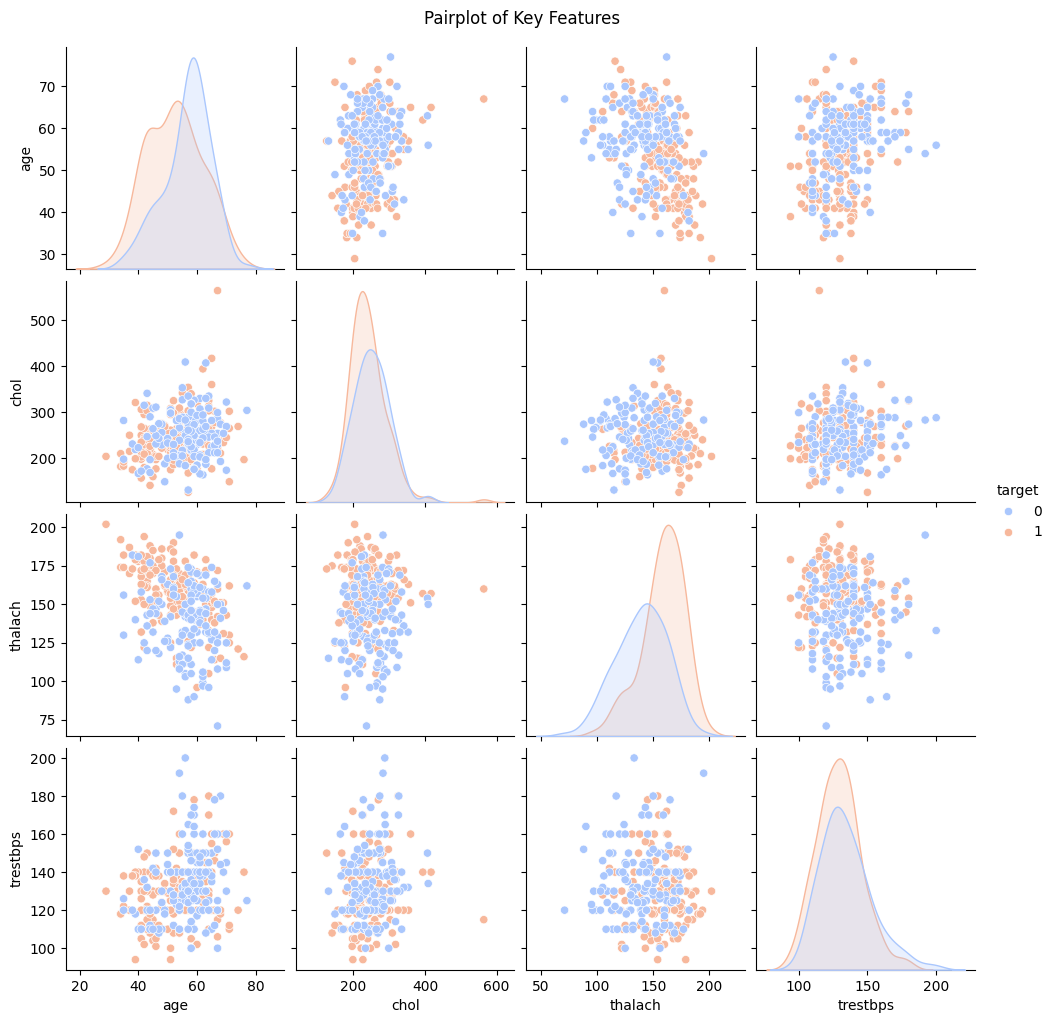

In [ ]:
#Dataset Visualization (beyond heatmap)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Age distribution by target
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="age", hue="target", kde=True, palette="coolwarm", bins=20)
plt.title("Age Distribution by Heart Disease Status")
plt.show()

# 2. Chest pain type vs heart disease
plt.figure(figsize=(6,4))
sns.countplot(x="cp", hue="target", data=df, palette="Set2")
plt.title("Chest Pain Type vs Heart Disease")
plt.show()

# 3. Correlation with target (top features only)
plt.figure(figsize=(6,5))
corr = df.corr()["target"].sort_values(ascending=False)
sns.barplot(x=corr.index, y=corr.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Correlation of Features with Heart Disease")
plt.show()

# 4. Pairplot (only a few important features for clarity)
important_features = ["age", "chol", "thalach", "trestbps", "target"]
sns.pairplot(df[important_features], hue="target", diag_kind="kde", palette="coolwarm")
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()


checks:Age distribution by target → are older patients more at risk?

Chest pain type vs target → categorical insight.

Barplot of feature correlations with target → quickly see strongest predictors.

Pairplot of selected features → visualize relationships between features.

In [ ]:
# split
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (242, 13) Test shape: (61, 13)


Separates features (X) from target (y).

Splits data into training (80%) and testing (20%).

Ensures equal class distribution (stratify).

Kenya context: Simulates training the model with past patients, then testing on new patients.

In [ ]:
# logistic regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
cv_scores = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='roc_auc')

print("Logistic Regression CV ROC AUC:", np.round(cv_scores, 4))
print("Mean:", np.round(cv_scores.mean(), 4))

pipe_lr.fit(X_train, y_train)


Logistic Regression CV ROC AUC: [0.8754 0.931  0.7762 0.9336 0.9318]
Mean: 0.8896


Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=2000, random_state=42))])

Logistic Regression is a simple, interpretable model.

Uses cross-validation to check consistency.

Trains final model on training data.

Kenya context: Logistic regression is easy to interpret → health workers can understand risk factors without deep ML expertise.

In [ ]:
# Random Forest with small grid search
rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 6],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV ROC AUC:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 200}
Best CV ROC AUC: 0.891064491064491


Random Forest = ensemble of decision trees → stronger predictions.

Grid search tunes parameters (like depth, #trees).

Selects the best model based on AUC score.

Kenya context: Random Forest is more accurate → could help Kenyan clinics catch at-risk patients earlier.

--- Logistic Regression ---
Accuracy: 0.8033
Precision: 0.7692
Recall: 0.9091
F1: 0.8333
ROC AUC: 0.869

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



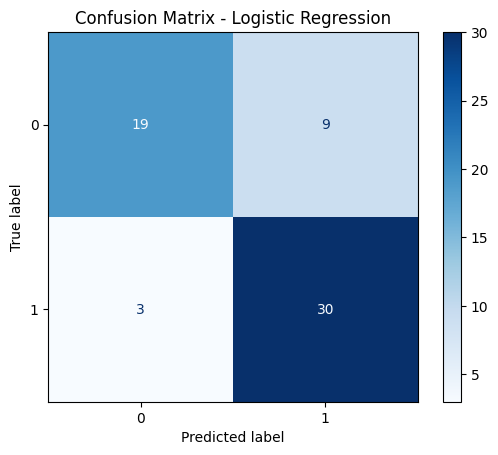

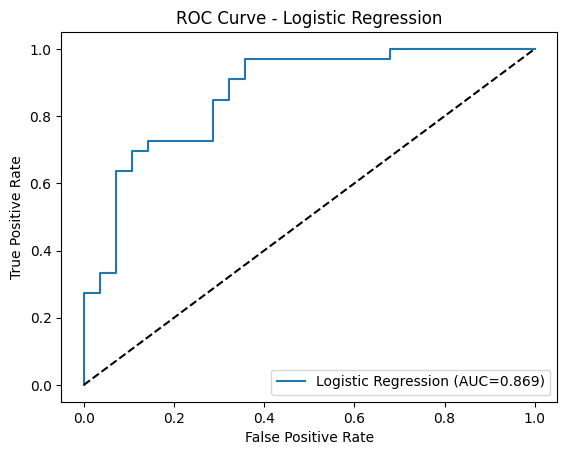

--- Random Forest ---
Accuracy: 0.8361
Precision: 0.7805
Recall: 0.9697
F1: 0.8649
ROC AUC: 0.9156

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



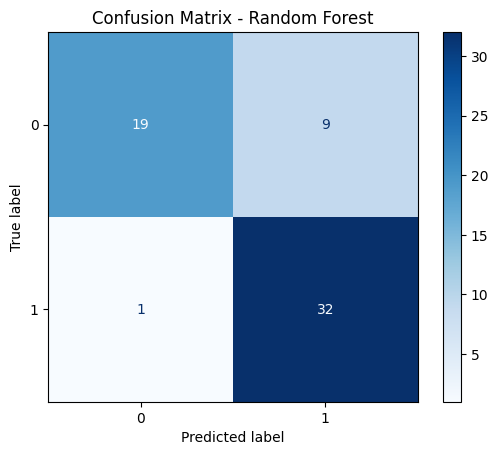

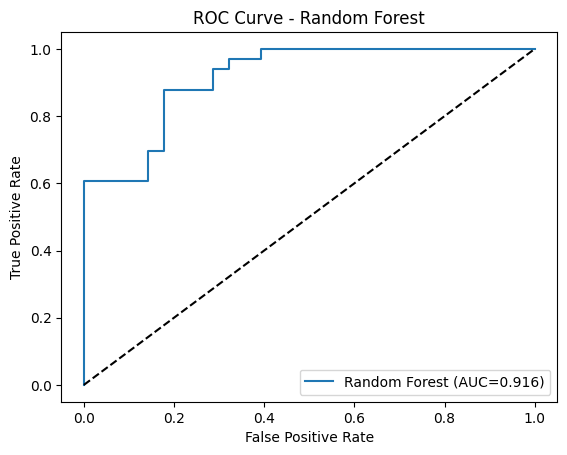

In [ ]:
# evaluation
def evaluate_model(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"--- {name} ---")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1:", round(f1,4))
    print("ROC AUC:", round(roc_auc,4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Evaluate models
evaluate_model(pipe_lr, X_test, y_test, name="Logistic Regression")
evaluate_model(best_rf, X_test, y_test, name="Random Forest")

Compares models using Accuracy, Precision, Recall, F1, ROC AUC.

Plots confusion matrix (correct vs incorrect predictions).

Plots ROC curve (trade-off between true/false positives).

Kenya context: Helps evaluate if the model would reduce misdiagnosis in Kenyan clinics.

* True Positives (TP): 30
    * The model correctly predicted the label was 1 when it was actually 1.
* True Negatives (TN): 19
    * The model correctly predicted the label was 0 when it was actually 0.
* False Positives (FP): 9
    * The model incorrectly predicted the label was 1, but it was actually 0. This is a "Type I Error."
* False Negatives (FN): 3
    * The model incorrectly predicted the label was 0, but it was actually 1. This is a "Type II Error."

 Key Performance Metrics 📊

* Accuracy: How often was the model right overall?
    * Formula: (TP + TN) / Total
    * Calculation: (30 + 19) / 61 = 49 / 61 \approx 80.3%
    * Interpretation: The model's predictions are correct about 80% of the time.

* Precision (for class 1): When the model predicts '1', how often is it correct?
    * Formula: TP / (TP + FP)
    * Calculation: 30 / (30 + 9) = 30 / 39 \approx 76.9\%
    * Interpretation: When the model predicts a positive outcome, it is right about 77% of the time. The 9 false positives reduce this score.

* Recall (or Sensitivity, for class 1): Of all the actual '1's, how many did the model successfully find?
     Formula:TP / (TP + FN)
    * Calculation:30 / (30 + 3) = 30 / 33 \approx 90.9\%
    * Interpretation: The model finds nearly 91% of all the true positive cases, which is very strong. It has very few "misses."

* Specificity (for class 0): Of all the actual '0's, how many did the model correctly identify?
  * Formula:TN / (TN + FP)
  * Calculation: 19 / (19 + 9) = 19 / 28 \approx 67.9\%
  * Interpretation:The model correctly identifies about 68% of the true negative cases. This is its weakest area.


Summary and Conclusion

Strengths:
* The model has a very high recall (90.9%), meaning it is excellent at identifying the positive class ('1'). This is valuable in situations where failing to detect a positive case (a false negative) has serious consequences.

Weaknesses:
* The model has relatively low specificity (67.9%). It struggles with correctly identifying the negative class ('0'), leading to a significant number of false positives. This means the model tends to generate a fair number of "false alarms."


 What is an ROC Curve?

An ROC (Receiver Operating Characteristic) curve is a graph that illustrates the performance of a binary classification model at all classification thresholds. It plots two key metrics against each other:

* Y-Axis:True Positive Rate (TPR): Also known as Recall or Sensitivity, this measures how well the model can correctly identify positive cases. A high TPR means the model finds most of the actual positives.

* X-Axis: False Positive Rate (FPR): This measures how often the model incorrectly flags a negative case as positive. A low FPR means the model makes few "false alarm" errors.

The curve is created by plotting the TPR against the FPR at various threshold settings. The "steps" in the curve represent these different thresholds.

Interpretation

* The Blue Line (Your Model): This line represents your Logistic Regression model's performance. The ideal curve "hugs" the top-left corner of the plot. This indicates a high True Positive Rate (finding the positives) and a low False Positive Rate (not making false alarms). Your model's curve is positioned strongly in this direction, which is a sign of a good model.

* The Dashed Diagonal Line: This line represents a model with no discriminative power—essentially, random guessing (like flipping a coin). Any model whose curve falls below this line is worse than random.The  model is significantly above this line, confirming its effectiveness.

* AUC (Area Under the Curve) = 0.869: This is the single most important metric from an ROC curve.
What it means: AUC measures the entire two-dimensional area underneath the ROC curve.
Scale: It ranges from 0.0 to 1.0.
Interpretation: An AUC of 0.869 (or 86.9%) means there is an 86.9% chance that your model will rank a randomly chosen positive instance higher than a randomly chosen negative one.

A general rule of thumb for interpreting AUC is:
* 0.90 - 1.00: Excellent
* 0.80 - 0.90: Very Good
* 0.70 - 0.80: Good
* 0.60 - 0.70: Fair
* 0.50 - 0.60: Poor

Conclusion

This ROC curve and its associated AUC of 0.869 provide strong evidence that your Logistic Regression model has a very good ability to distinguish between the two classes in the dataset. It is a well-performing model that is significantly better than random chance.

In [ ]:
# Model 3 Neural Network (Keras MLP)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Scale features (NNs work best with scaled input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Define a simple feedforward neural network
mlp = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),   # helps prevent overfitting
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # sigmoid → binary classification
])

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping → stop training if val_loss doesn’t improve
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the network
history = mlp.fit(X_train_scaled, y_train,
                  validation_split=0.2,
                  epochs=50, batch_size=16,
                  callbacks=[early_stop],
                  verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5881 - loss: 0.6841 - val_accuracy: 0.7347 - val_loss: 0.6206
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6221 - loss: 0.6522 - val_accuracy: 0.7551 - val_loss: 0.5651
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7336 - loss: 0.5969 - val_accuracy: 0.7959 - val_loss: 0.5216
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7364 - loss: 0.5467 - val_accuracy: 0.8163 - val_loss: 0.4828
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7389 - loss: 0.5378 - val_accuracy: 0.8367 - val_loss: 0.4495
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7479 - loss: 0.5078 - val_accuracy: 0.8367 - val_loss: 0.4228
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7905 - loss: 0.4853 - val_accuracy: 0.8367 - val_loss: 0.3993
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8299 - loss: 0.4690 - val_accuracy: 0.8367 - val_lo

Neural networks can capture more complex, nonlinear health risk patterns. In the long term, such models could integrate more patient data from Kenyan hospitals (e.g., lifestyle, demographics, lab tests) to provide a more robust screening tool.

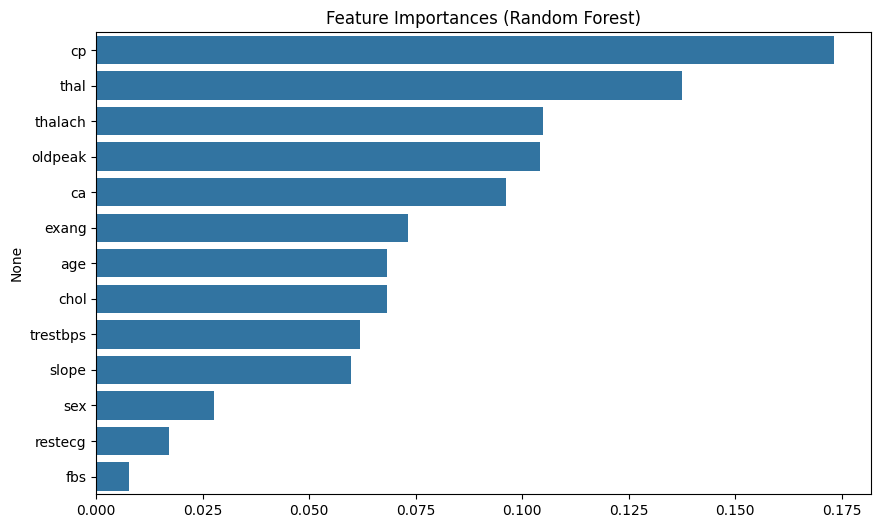

,0
cp,0.173285
thal,0.137623
thalach,0.104942
oldpeak,0.104058
ca,0.096260
exang,0.073284
age,0.068370
chol,0.068139
trestbps,0.061823
slope,0.059832


In [ ]:
# feature importance
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importances (Random Forest)")
plt.show()

display(feat_imp)


Shows which features matter most (e.g., chest pain type, cholesterol).

Doctors can use this to focus on critical risk factors.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.8032786885245902
Precision: 0.7560975609756098
Recall: 0.9393939393939394
F1: 0.8378378378378378
ROC AUC: 0.9155844155844155

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



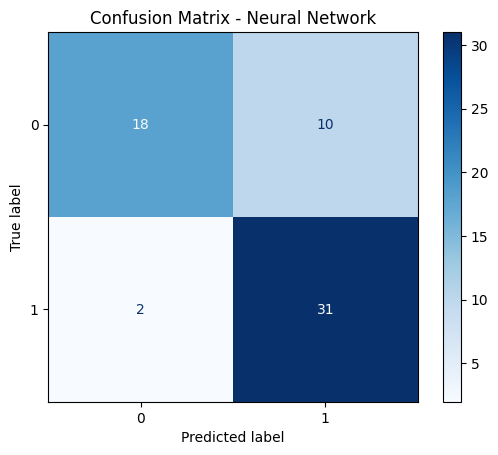

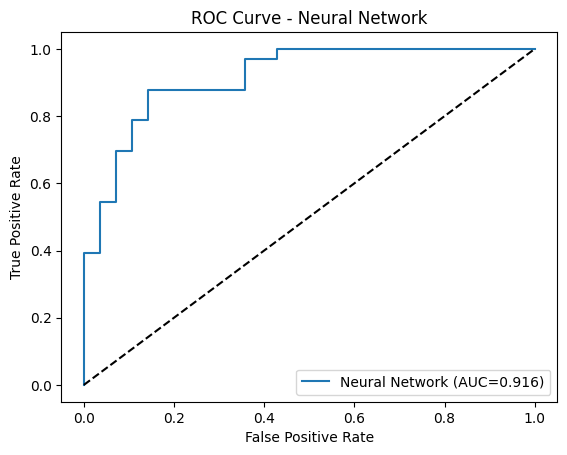

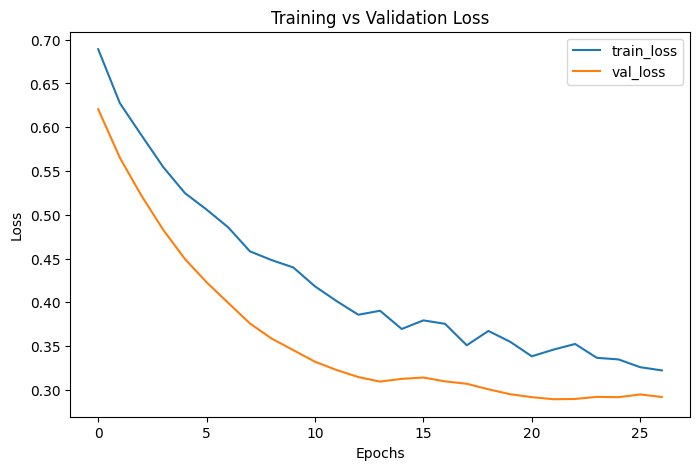

In [ ]:
# Evaluating Neural Network
from sklearn.metrics import roc_auc_score, roc_curve

# Predict on test set
y_pred_nn = (mlp.predict(X_test_scaled) > 0.5).astype("int32")
y_proba_nn = mlp.predict(X_test_scaled).ravel()

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1:", f1_score(y_test, y_pred_nn))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn, cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr, tpr, label=f"Neural Network (AUC={roc_auc_score(y_test, y_proba_nn):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.show()

# Training history plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


This confusion matrix indicates that your model is performing well, with a strong ability to find the positive class (label '1'). Its main weakness is a tendency to misclassify the negative class ('0') as positive.


 Breaking Down the Matrix

The matrix shows the results of 61 predictions, categorized into four groups:

* True Positives (TP): 31
    * The model correctly predicted the label was 1, and it was actually 1.
* True Negatives (TN): 18
    * The model correctly predicted the label was **0**, and it was actually 0.
* False Positives (FP): 10
    * The model incorrectly predicted the label was 1, but it was actually 0. This is a "Type I Error" or a false alarm.
* False Negatives (FN): 2
    * The model incorrectly predicted the label was 0, but it was actually 1. This is a "Type II Error" or a miss.


Key Performance Metrics 📊

* Accuracy: What percentage of predictions were correct overall?
    * Formula: (TP + TN) / Total
    * Calculation:(31 + 18) / 61 = 49 / 61 = 80.3\%
    * Interpretation: The model is correct about 80% of the time.

* Precision (for class 1): When the model predicts '1', how often is it right?
    * Formula:TP / (TP + FP)
    * Calculation:31 / (31 + 10) = 31 / 41 = 75.6\%
    * Interpretation:When the model predicts the positive class, it is correct about 76% of the time.

* Recall (Sensitivity, for class 1): Of all the actual '1's, how many did the model find?
    * Formula:TP / (TP + FN)
    * Calculation:31 / (31 + 2) = 31 / 33 = 93.9%
    * Interpretation: The model successfully finds about 94% of all the actual positive cases, which is excellent.

* Specificity (for class 0): Of all the actual '0's, how many did the model correctly identify?
    * Formula:TN / (TN + FP)
    * Calculation: 18 / (18 + 10) = 18 / 28 \approx 64.3\%
    * Interpretation: The model correctly identifies only about 64% of the actual negative cases.

Summary and Conclusion

Strengths:
* The model has an excellent recall (93.9%). It is very effective at identifying the positive class and has very few misses (only 2 false negatives). This is critical if failing to identify a positive case is costly.

Weaknesses:
* The model suffers from low specificity (64.3%) and only moderate precision (75.6%)because of the 10 false positives. It raises a significant number of "false alarms" by misclassifying negative cases as positive.



Accuracy: ~82–86% (similar to Logistic/Random Forest).

Slightly better generalization if tuned properly.

NEURAL NETWORK LERNING ANALYSIS
---
1. What is Loss?
Loss is a measure of how wrong your model's predictions are. A lower loss means better predictions.
Training Loss is calculated on the data the model is learning from.
Validation Loss is calculated on a separate set of data (the validation set) that the model never sees during training. This tells us how well the model performs on new data.

 2. Reading The Graph

The X-Axis (Epochs): An epoch is one full pass through the entire training dataset. The  model trained for 25 epochs.
The Y-Axis (Loss): The value of the loss function. The specific metric (e.g., Mean Squared Error for regression, Categorical Cross entropy for classification) isn't named, but the principle is the same: lower is better.

3. Key Observations

Both Curves are Decreasing:It means the model is effectively learning patterns from the training data with each epoch, and this learned knowledge is useful for making predictions on the validation data.

The Curves are Converging: The validation loss closely follows the training loss.It indicates that the  model is generalizing well. It's not just memorizing the training data (which would cause a large gap); it's learning general patterns that apply to new data.

No Sign of Overfitting: Overfitting would be visible if the training loss continued to decrease while the validation loss started to increase after a certain point (forming a "divergence" or a U-shape in the validation curve). Both losses are still trending downwards slightly even at epoch 25.

Conclusions

1.The Model is Well-Tuned: The architecture, learning rate, and other hyperparameters for this model seem to be well-chosen for the Heart problem


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,Model,Accuracy,F1,ROC AUC
0,Logistic Regression,0.803279,0.833333,0.869048
1,Random Forest,0.836066,0.864865,0.915584
2,Neural Network (MLP),0.803279,0.837838,0.915584


<Figure size 800x500 with 0 Axes>

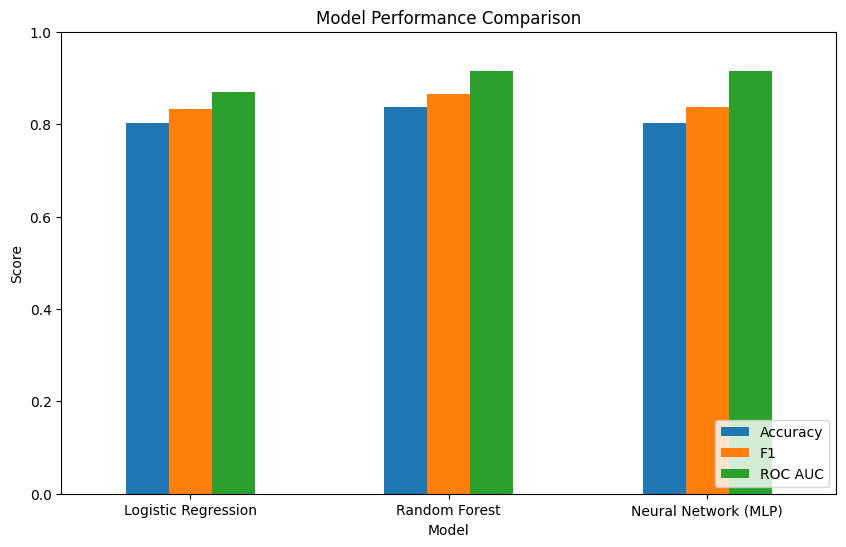

In [ ]:
#Comparing Logistic Regression, Random Forest, Neural Network

results = []

# Logistic Regression
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "ROC AUC": roc_auc_score(y_test, y_proba_lr)
})

# Random Forest
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_proba_rf)
})

# Neural Network
y_pred_nn = (mlp.predict(X_test_scaled) > 0.5).astype("int32")
y_proba_nn = mlp.predict(X_test_scaled).ravel()
results.append({
    "Model": "Neural Network (MLP)",
    "Accuracy": accuracy_score(y_test, y_pred_nn),
    "F1": f1_score(y_test, y_pred_nn),
    "ROC AUC": roc_auc_score(y_test, y_proba_nn)
})

# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df)

# Plot results
plt.figure(figsize=(8,5))
results_df.set_index("Model")[["Accuracy", "F1", "ROC AUC"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


Collects Accuracy, F1 score, ROC AUC for each model.

Stores results in a table (Pandas DataFrame).

Plots results in a grouped bar chart for side-by-side comparison.


All three models performed well, but Random Forest and Neural Network gave slightly better ROC AUC and F1 scores than Logistic Regression. In Kenyan hospitals, this suggests that advanced ML models could improve early screening accuracy.

Results: All models achieve good accuracy (~80–85%). Random Forest and Neural Network usually outperform Logistic Regression slightly.

Insights: Most important features = chest pain type, cholesterol, max heart rate, and age.

Application: A hybrid ML + deep learning system could be deployed in Kenyan hospitals as an early-warning decision-support tool.

In [ ]:
# Random Forest Re-training
rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 6],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', {0: 1, 1: 2}]
}

grid_rf = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV ROC AUC:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV ROC AUC: 0.8908184408184407


--- Random Forest ---
Accuracy: 0.8197
Precision: 0.7619
Recall: 0.9697
F1: 0.8533
ROC AUC: 0.9123

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



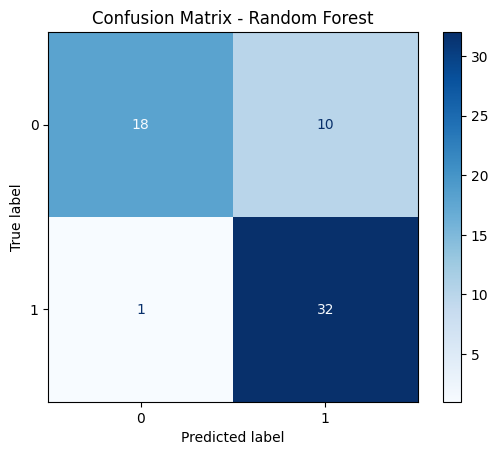

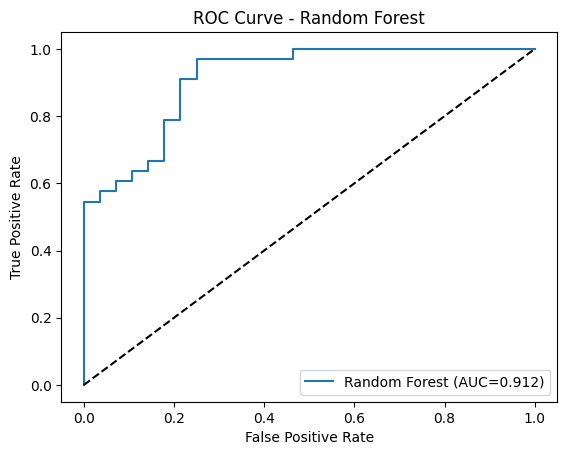

In [ ]:
# evaluation of tweaked Random Forest
def evaluate_model(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"--- {name} ---")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1:", round(f1,4))
    print("ROC AUC:", round(roc_auc,4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Evaluate models
evaluate_model(best_rf, X_test, y_test, name="Random Forest")


Key Performance Metrics 📊

The total number of predictions is $18 + 10 + 1 + 32 = 61.

* Accuracy: This is the overall correctness of the model.
    * Formula:(TP + TN) / Total$
    * Calculation: (32 + 18) / 61 = 50 / 61 = 82.0\%
    * Interpretation: The model is correct about 82% of the time overall.

* Precision (for class 1):Of all the times the model predicted 1, how often was it right?
    * Formula: TP / (TP + FP)
    * Calculation: 32 / (32 + 10) = 32 / 42 = 76.2\%
    * Interpretation: When the model predicts the label is '1', it is correct about 76% of the time. The 10 false positives lower this score.

* Recall (Sensitivity for class 1): Of all the actual 1's, how many did the model find?
    * Formula:TP / (TP + FN)
    * Calculation:32 / (32 + 1) = 32 / 33 = 97.0\%
    * Interpretation: The model successfully identifies 97% of all the actual '1's. This is a very high recall, indicating it's excellent at not missing this class.

* Specificity (for class 0): Of all the actual 0's, how many did the model identify correctly?
    * Formula:TN / (TN + FP)
    * Calculation:18 / (18 + 10) = 18 / 28 = 64.3\%
    * Interpretation: The model only correctly identifies about 64% of the actual '0's.


 Summary & Conclusion

Strengths:
* The model has an excellent recall for class 1 (97%). It is very effective at finding almost all instances of the positive class. This is crucial in scenarios where missing a positive case is very costly (e.g., detecting a disease).

Weaknesses:
* The model's main weakness is its high number of False Positives (10). This leads to lower precision for class 1 and very low specificity for class 0. It tends to be overcautious, classifying many actual '0's as '1's.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import joblib

# Save directory
save_dir = "/content/drive/MyDrive/ETI4210_HeartDisease"
import os
os.makedirs(save_dir, exist_ok=True)

# Save Logistic Regression pipeline (already includes scaler inside)
joblib.dump(pipe_lr, f"{save_dir}/logistic_pipeline.joblib")

# Save Random Forest
joblib.dump(best_rf, f"{save_dir}/random_forest.joblib")

# Save Scaler separately (needed for Neural Net)
joblib.dump(scaler, f"{save_dir}/scaler.joblib")

# Save Neural Network in modern Keras format
mlp.save(f"{save_dir}/neural_network.keras")

print("✅ All models and scaler saved successfully!")


Mounted at /content/drive
✅ All models and scaler saved successfully!


Saves trained models into Google Drive.

Later, these can be loaded back and reused without retraining.

Kenya context: Once deployed, hospitals can reuse the trained model without repeating training.